# Mathematical Foundations of Computer Graphics and Vision 2022
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. If using this notebook, please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems, buy you may create new cells should you find that necessary. 

In [73]:
%matplotlib inline
import math
from typing import Tuple, List
import itertools
from collections import namedtuple

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


# Defining objects to store Circle/Line objects
Circle = namedtuple("Circle", ["origin", "radius"])
Line = namedtuple("Line", ["a", "b"])

## Part 1: RANSAC for circle fitting

In [74]:
N = 100  # number of total points
D = 10  # half-domain size
R = 5  # radius of the default circle
tau = 0.1  # inlier distance threshold

### 1.1. Data generation

In [75]:
def is_circle_inlier(points: np.ndarray, circle: Circle) -> np.ndarray:
    """
    points - Nx2 array with the data points
    circle - Circle object to test against
    
    Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
    """
    is_inlier = np.ones((points.shape[0],), dtype=bool)
    
    # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
    # Use `circle.origin` and `circle.radius` to access attributes of Circle
    # START
    for i in range(0,len(points)):
        l2_norm = np.linalg.norm(points[i]-circle.origin,2)
        inline = np.abs(circle.radius-l2_norm) <= tau
        if not inline:
            is_inlier[i] = False
    # END
    return is_inlier

def generate_circle_points(r, n_points=N, circle: Circle = Circle((0, 0), R)) -> Tuple[np.ndarray, np.ndarray]:
    """
    r - outlier ratio
    n_points - number of points to generate
    circle - circle model for the inliers
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the respective points
    """
    n_outliers = int(n_points * r)
    n_inliers = n_points - n_outliers
    
    inliers = np.random.uniform(-D, D, (n_inliers, 2))
    outliers = np.random.uniform(-D, D, (n_outliers, 2))
    
    # TODO : Implement Task 1.1. You can use `is_circle_inlier` for that
    # START
    # Generate inliers
    count = 0
    while(count< n_inliers):
        # Generate points randomly on circle with random 
        in_line = []
        for i in range(0,n_inliers):
            alpha = 2*math.pi*np.random.random()
            r = np.random.uniform(circle.radius-tau,circle.radius+tau)
            in_line.append([r*math.cos(alpha)+circle.origin[0],r*math.sin(alpha)+circle.origin[1]])

        # Sanity check - check if these are actually correct and the add
        check_inliers = is_circle_inlier(np.array(in_line),circle)
        for i in range(0,n_inliers):
            if check_inliers[i]:
                inliers[count] = in_line[i]
                count+=1
    # Generate outliers
    out_line = []
    while(len(out_line) < n_outliers):
        check_inliers = is_circle_inlier(outliers,circle)
        for i in range(0,len(outliers)):
            # If outlier, add if not enough
            if check_inliers[i]==False and len(out_line)<n_outliers:
                out_line.append(outliers[i])
        # Generate more new points than needed
        outliers = np.random.uniform(-D,D,(n_outliers,2))
    outliers = np.array(out_line) if len(out_line) > 0 else np.empty((0,2))
    # END 
    
    return inliers, outliers

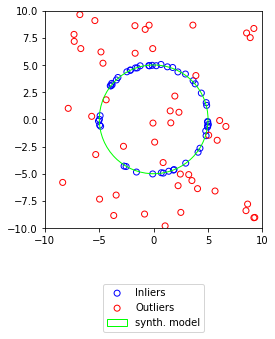

In [76]:
# Helper class to plot your results. No need to edit this, if `generate_circle_points` is implemented correctly
def plot_ransac_result(ax, inliers, outliers, ransac_model: Circle, synth_model: Circle):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    if ransac_model is not None:
        ransac_circle = plt.Circle(synth_model.origin, synth_model.radius, color='black', label='RANSAC model', fill=False)
        ax.add_patch(ransac_circle)
        
    synth_circle = plt.Circle(synth_model.origin, synth_model.radius, color='lime', label='synth. model', fill=False)
    ax.add_patch(synth_circle)
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers 
inliers, outliers = generate_circle_points(0.5)
fig, ax = plt.subplots()
plot_ransac_result(ax, inliers, outliers, None, Circle((0, 0), R))
plt.show()
plt.close(fig)

### 1.2. RANSAC

In [77]:
def fit_circle(points: np.ndarray) -> Circle:
    """
    points - 3x2 array
    
    Returns - Circle going through all the `points`
    """
    if points.shape != (3, 2):
        raise ValueError("Bad number of points")
    
    x = 0
    y = 0
    radius = 1
    
    # TODO : Compute circle origin (x, y) and radius that goes through all three `points`
    # START 
    c = (points[0][0]-points[1][0])**2 + (points[0][1]-points[1][1])**2
    a = (points[1][0]-points[2][0])**2 + (points[1][1]-points[2][1])**2
    b = (points[2][0]-points[0][0])**2 + (points[2][1]-points[0][1])**2

    s = 2*(a*b + b*c + c*a) - (a*a + b*b +c*c)
    x = (a*(b+c-a)*points[0][0] + b*(c+a-b)*points[1][0] + c*(a+b-c)*points[2][0]) / s
    y = (a*(b+c-a)*points[0][1] + b*(c+a-b)*points[1][1] + c*(a+b-c)*points[2][1]) / s 
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    radius = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    # END 
    
    return Circle((x, y), radius)

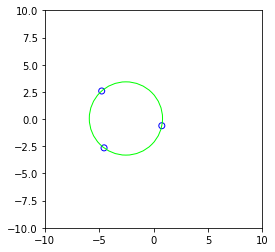

In [78]:
# Testing `fit_circle` implementation. No need to edit this
def plot_fitted_circle(points, circle: Circle):
    fig, ax = plt.subplots()
    plot_ransac_result(ax, points, points[:0], None, circle)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)
    
points = np.random.uniform(-D//2, D//2, (3, 2))
circle = fit_circle(points)

plot_fitted_circle(points, circle)

In [79]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate
    
    Returns - number of RANSAC iterations to achieve `p` success rate 
    """
    n = 1
    
    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START 
    
    # Ceil just to be sure
    n = math.ceil(math.log(1-p)/math.log(1-(1-r)**sample_size))
    # END 
    
    return n

In [80]:
# STUDENT DEFINED FUNCTION
# Get three random indices i1,i2,i3
# IN: min (int), max (int) - boundary elements [min,max)
# OUT: i1,i2,i3 (int) : three distinct random indices
def get_random_indicies(min,max):
    while True:
        i1 = np.random.randint(low=min,high=max,dtype=int)
        i2 = np.random.randint(low=min,high=max,dtype=int)
        i3 = np.random.randint(low=min,high=max,dtype=int)
        if i1!=i2 and i2!=i3 and i3!=i1:
            return i1,i2,i3

In [81]:
def run_ransac(points: np.ndarray, n_iter: int) -> Tuple[np.ndarray, np.ndarray, Circle]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Circle model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    circle = None
    
    # TODO : Implement 1.2 - RANSAC for circle fitting
    # START
    for i in range(0,n_iter):
        ## Choose three, distinct points
        i1,i2,i3 = get_random_indicies(0,n_points)
        # Fit circle
        pos_circle = fit_circle(np.array([points[i1],points[i2],points[i3]]))
        
        # Check possible inliers/outliers
        check_in = is_circle_inlier(points,pos_circle)
        pos_inliers  =  points[check_in==True]
        pos_outliers =  points[check_in==False]

        # Set best
        if inliers.shape[0]<pos_inliers.shape[0]:
            inliers = pos_inliers
            outliers = pos_outliers
            circle = pos_circle

    # END 
    
    return inliers, outliers, circle

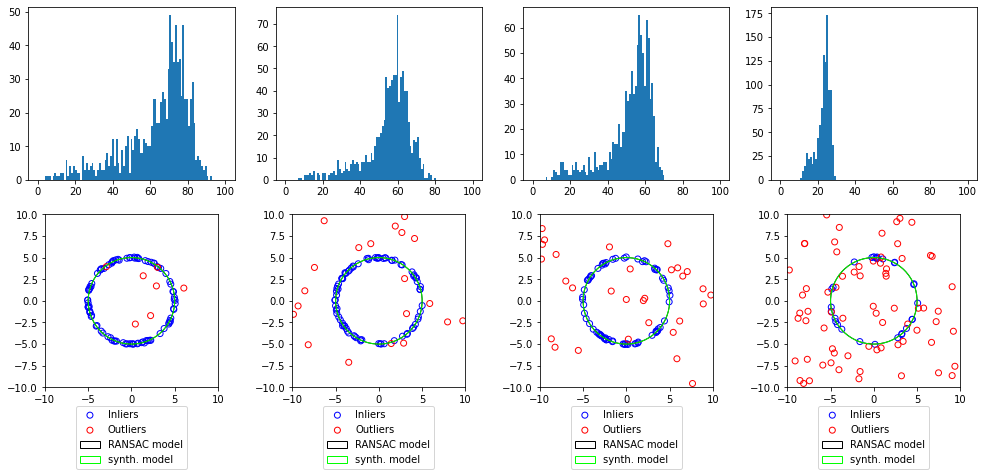

In [82]:
# Running RANSAC and populating historgrams
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))

for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)): 
    inlier_histogram = np.zeros(N_RUNS)
    
    ransac_inliers = None
    ransac_outliers = None
    circle = None
    
    # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
    #        `ransac_outliers`, `circle`
    # START
    inliers,outliers = generate_circle_points(r,100,Circle((0,0),R))
    points = np.concatenate((inliers,outliers),0)
    n_iter = get_ransac_iterations(r,3,0.99)
    for j in range(0,N_RUNS):
        in_line, out_line, pos_circle = run_ransac(points,n_iter)
        inlier_histogram[j]=in_line.shape[0]
        if ransac_inliers is None or in_line.shape[0] > ransac_inliers.shape[0]:
            ransac_inliers = in_line
            ransac_outliers = out_line
            circle = pos_circle
        
    # END
    
    ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)
    
    plot_ransac_result(ax_vis, ransac_inliers, ransac_outliers, circle, Circle((0, 0), R))

plt.show()
plt.close(fig)

### 1.3. Exhaustive search

In [83]:
def exhaustive_search(points: np.ndarray) -> Tuple[np.ndarray, np.ndarray, Circle]:
    """
    points - Nx2 array with the data points
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best Circle model
    """

    n_points = points.shape[0]

    inliers = points[:0]
    outliers = points
    circle = None

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START
    for subset in itertools.combinations(points,3):
        pos_circle = fit_circle(np.array(subset))
        check_in = is_circle_inlier(points,pos_circle)
        in_line = points[check_in]
        out_line = points[check_in==False]
        if in_line.shape[0]>inliers.shape[0]:
            inliers=in_line
            outliers=out_line
            circle=pos_circle
    # END 
    
    return inliers, outliers, circle

Real inliers: 16
RANSAC inliers: 14
Exhaustive search inliers: 16


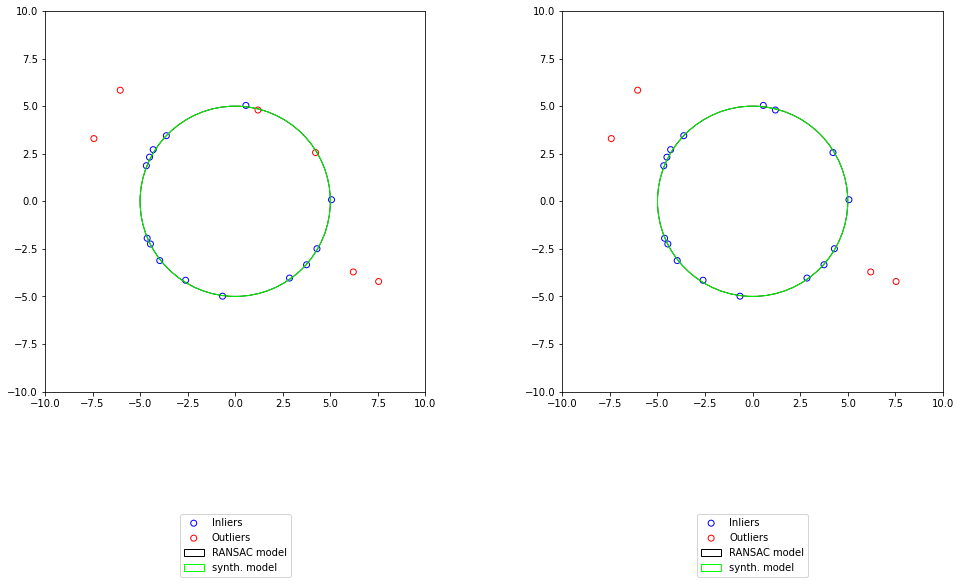

In [84]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = generate_circle_points(0.2, 20)
points = np.concatenate((inliers, outliers), 0)
n_iter = get_ransac_iterations(0.2, 3, 0.99)
ransac_inliers, ransac_outliers, circle = run_ransac(points, n_iter)

exhaustive_inliers, exhaustive_outliers, exhaustive_circle = exhaustive_search(points)
print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))
plot_ransac_result(axes[0], ransac_inliers, ransac_outliers, circle, Circle((0, 0), R))

plot_ransac_result(axes[1], exhaustive_inliers, exhaustive_outliers, exhaustive_circle, Circle((0, 0), R))
plt.show()
plt.close(fig)

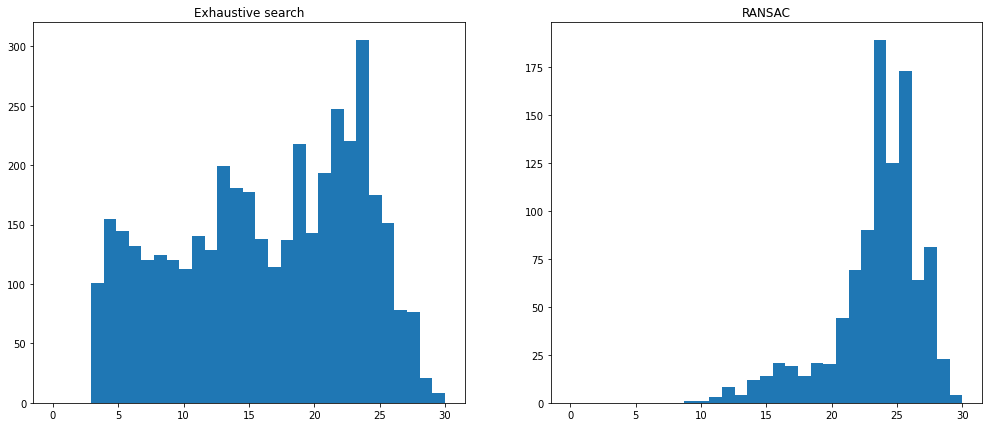

In [85]:
def exhaustive_search_histogram(inliers: np.ndarray, points: np.ndarray) -> List[int]:
    """
    inliers - Nx2 array with the true inliers from the synthetic model
    points - Nx2 array with the data points
    
    Returns - list of number of inliers for each of the samples
    """
    n_points = points.shape[0]
    
    nb_inliers_list = []
    
    # TODO : Populate `nb_inliers_list` by running exhaustive search on synthetic inliers
    #        and counting the number of found inliers in `points`
    # START
    for subset in itertools.combinations(inliers,3):
        pos_circle = fit_circle(np.array(subset))
        check_in = is_circle_inlier(points,pos_circle)
        nb_inliers_list.append(points[check_in].shape[0])
    # END 
    return nb_inliers_list


def compare_ransac_and_exhaustive_search():
    r = 0.7
    inliers, outliers = generate_circle_points(r)
    points = np.concatenate((inliers, outliers), 0)
    
    exhaustive_histogram = exhaustive_search_histogram(inliers, points)
    
    ransac_histogram: List[int] = []
        
    # TODO : Populate `ransac_histogram` by running RANSAC 1000 times
    # START
    n_iter = get_ransac_iterations(r,3,0.99)
    for i in range(0,1000):
        in_line, out_line, pos_circle = run_ransac(points,n_iter)
        ransac_histogram.append(in_line.shape[0])
    # END

    # Plotting the results
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))
    
    axes[0].hist(np.array(exhaustive_histogram), range=(0, 30), bins=31)
    axes[0].set_title('Exhaustive search')

    axes[1].hist(np.array(ransac_histogram), range=(0, 30), bins=31)
    axes[1].set_title('RANSAC')


compare_ransac_and_exhaustive_search()

### Questions and Discussion 

<b style="color:red"> Question 1: </b> How many combinations (exhaustive search) exist for $N=100$ points? 

* (100 choose 3) = 161700 possible combinations

<b style="color:red"> Question 2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$? 

* For r = 5%: ~2.36 -> 3 iterations
* For r = 20%: ~6.42 -> 7 iterations
* For r = 70%: ~168.25 -> 169 iterations

(We round up the number of iterations to the nearest integer. 1 iteration is cheap, but might produce a better result.)

<b style="color:red"> Question 3: </b> What about when $N=100,000$ points?

* For RANSAC ->  the numbers of iterations does not change.

* For exhaustive search -> we have 166661670000000 possible combinations

<b style="color:red"> Question 4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

The exhaustive search gurantees a global optimum.

However, the inliers are generated around a given circle (radius +/- tau), meaning that there might not exist three inliers that directly lie on the circle (distance of point to the origin == radius). The search will find a best circle that goes through the three inliers, but it does not gurantee all the created inliers will be marked as such.

<b style="color:red"> Question 5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations improve that?

RANSAC does not always find the clost-to-optimal number of inliers as it is a probabilistic algorithm. As the number of iterations goes to infinity, the probability of finding an optimal solution is also going to 1, but it practice - it can never be guranteed.

<b style="color:red">Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.</b>

RANSAC: 
* faster, but the resulting numbers of inliers may vary (due to the probabilistic approach), as the result is only a local optimum. 
* each execution of the algorithm might produce different result
* the number of iterations does not scale with the number of samples
* uses hyperparameters - the result may vary based on their values

Exhaustive search:
* slower algorithm, but it gurantees a global optimum 
* as a deterministic algorithm, it always produces the same, optimal result
* the number of iterations grows exponentially with the number of samples
* no hyperparameters

## Part 2: IRLS and norms for line fitting

In [86]:
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

TEST_LINE = Line(1, 1)

### Data generation

In [87]:
def is_line_inlier(points: np.ndarray, line: Line) -> np.ndarray:
    """
    points - Nx2 array with the data points
    line - Line object to test against
    
    Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
    """
    is_inlier = np.ones((points.shape[0],), dtype=bool)
    
    # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
    # Use `line.a` and `line.b` to access attributes of a line
    # START
    for i in range(0,points.shape[0]):
        y = line.a*points[i][0]+line.b
        inline = np.abs((points[i][1]-y))<=tau
        if not inline:
            is_inlier[i]=False
    # END
    
    return is_inlier
    

def generate_line_points(r: float, n_points=N, line: Line = TEST_LINE) -> np.ndarray:
    """
    r - outlier ratio
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the respective points
    """
    n_outliers = int(n_points * r)
    n_inliers = n_points - n_outliers
    
    inliers = np.random.uniform(-D, D, (n_inliers, 2))
    outliers = np.random.uniform(-D, D, (n_outliers, 2))
    
    # TODO : Implement data points generation, following similar strategy as in Part 1
    # START
    # Generate inliers
    counter = 0
    while counter<n_inliers:
        # Generate points
        in_line = []
        for i in range(0,n_inliers):
            x = np.random.uniform(-D,D)
            y = np.random.uniform(line.a*x+line.b-tau,line.a*x+line.b)
            in_line.append([x,y])
        # Sanity check - check if these are actually correct and the add
        in_check = is_line_inlier(np.array(in_line),line)
        for i in range(0,len(in_line)):
            if in_check[i] and counter<n_inliers:
                inliers[counter] = in_line[i]
                counter+=1
    # Generate outliers
    out_line = []
    while len(out_line)< n_outliers:
        in_check = is_line_inlier(outliers,line)
        for i in range(0,outliers.shape[0]):
            if len(out_line)<n_outliers and in_check[i]==False:
                out_line.append(outliers[i])
        outliers = np.random.uniform(-D, D, (n_outliers, 2))
    outliers = np.array(out_line) if len(out_line) > 0 else np.empty((0,2))
    # END
                
    
    return np.concatenate((inliers, outliers), 0)

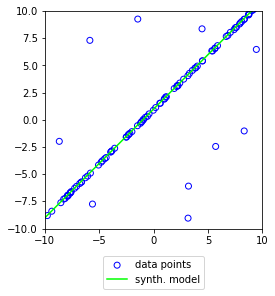

In [88]:
# Plotting the generated line, no need to change this code
def plot_line(ax, points, fitted_model: Line, synth_model: Line, title=None):
    def _plot_line(line: Line, label, color):
        x = np.linspace(-D, D, 100)
        y = line.a * x + line.b
        ax.plot(x, y, label=label, color=color)
        
    ax.scatter(points[:, 0], points[:, 1], label="data points", c='none', edgecolors='blue')
    
    if fitted_model is not None:
        _plot_line(fitted_model, 'fitted model', 'black')
        
    _plot_line(synth_model, 'synth. model', 'lime')
    
    if title is not None:
        ax.set_title(title)
        
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.3), loc="lower center")
    
points = generate_line_points(0.1)
fig, ax = plt.subplots()
plot_line(ax, points, None, Line(1, 1))
plt.show()
plt.close(fig)

In [89]:
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    line = Line(0.5, 0)
    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START

    # Data: Each point as x_0, x_1, where x_0 = 1 for all points
    X=np.column_stack((np.ones(shape=(points.shape[0],), dtype=int),points[:,0]))
    # Target variables 
    Y=points[:,1]

    # Starting coefficients and weights
    B = np.array([1,1])
    W = np.ones(shape=(points.shape[0],), dtype=int)
    
    max_iter = 30
    tolerance = 0.001
    for epoch in range(max_iter):
        # Calculate cost:
        # d = |ax+b-y|
        B_ = B
        distance = np.abs(np.sum(X*B,axis=1)-Y)
        # w_i = 1/2*distance^(-1)
        W=np.diag(0.5*distance**(-1))
        # Solution for least squares ->
        # B = inv(X'WX)X'WY
        B = np.linalg.inv(X.T@W@X)@X.T@W@Y
        tol = sum(abs(B-B_))
        if tol < tolerance:
            break
    line = Line(B[1],B[0])
    # END
    return line
points = generate_line_points(0.1,100)
fit_line_irls_l1(points)

def fit_line_lp_l1(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """   
    line = Line(0.5, 0)

    # TODO : Implement line fitting with L-1 norm by using linear programming
    # START
    # c -> a,b and t_x for each x
    c = np.concatenate((np.array([0,0]),np.ones(shape=(points.shape[0],),dtype=int)),axis=0)
    A=[]
    b=[]
    for i in range(0,len(points)):

        # -ax_i -b
        coeffs = np.array([-points[i][0],-1])
        # i times 0, -1, (# points-i-1) times 0 -> array of coefficients for each ith point where only ith coeff is set 
        coeffs = np.concatenate((coeffs,np.zeros(shape=(i,),dtype=int),np.array([-1]),np.zeros(shape=(points.shape[0]-i-1,),dtype=int)),axis=0)

        # -ax -b - t_i <= -y
        A.append(coeffs)
        b.append(-points[i][1])

        coeffs2 = np.array([points[i][0],1])
        # i times 0, -1, (# points-i-1) times 0 -> array of coefficients for each ith point where only ith coeff is set 
        coeffs2 = np.concatenate((coeffs2,np.zeros(shape=(i,),dtype=int),np.array([-1]),np.zeros(shape=(points.shape[0]-i-1,),dtype=int)),axis=0)

        # ax + b - t_i <= y 
        A.append(coeffs2)
        b.append(points[i][1])
    bounds = [(None,None),(None,None)]
    for point in points:
        bounds.append((0,None))
    res=linprog(c=c,A_ub=A, b_ub=b,bounds=bounds, options={"cholesky":False})
    coeff = res.get("x")
    line = Line(coeff[0],coeff[1])
    # END
    
    return line


def fit_line_lp_l_inf(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    line = Line(0.5, 0)
    
    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START
    # c = a,b and t
    c = (0,0,1)
    A = []
    b = []
    for point in points:
        # |y-(ax+b)| <= t -> -ax-b-t <= -y and ax+b-t<=y

        # -ax-b-t<=-y
        A.append([-point[0],-1,-1])
        b.append(-point[1])

        # ax+b-t<=y
        A.append([point[0],1,-1])
        b.append(point[1])
    a_bounds = (None,None)
    b_bounds = (None,None)
    t_bounds = (0,None)
    res=linprog(c=c,A_ub=A, b_ub=b,bounds=[a_bounds,b_bounds,t_bounds])
    coeff = res.get("x")
    line = Line(coeff[0],coeff[1])
    # END
    
    return line

C:\Users\werer\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.94281e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


IRLS L1: Line(a=1.0000694152558252, b=0.9533595853901313)
LP L1: Line(a=0.9998548347577431, b=0.9503826820767955)
LP L-inf: Line(a=1.000269869175531, b=0.9486655553951376)


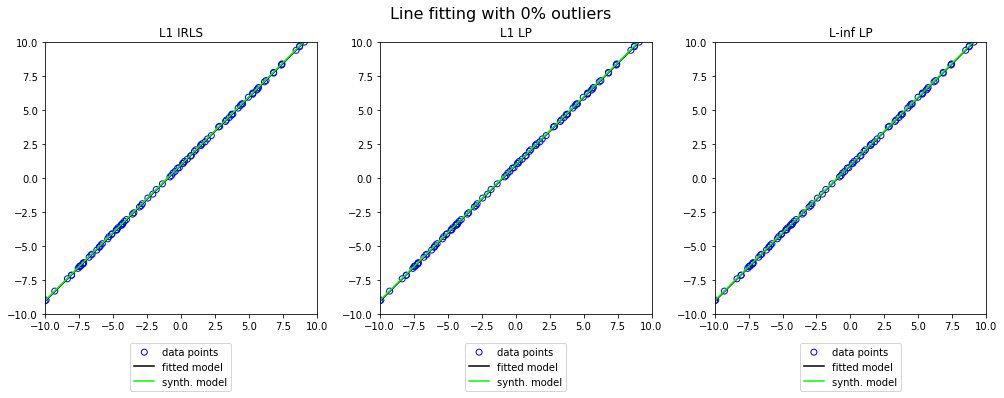

C:\Users\werer\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.49698e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


IRLS L1: Line(a=1.0002878731092197, b=0.9587416348605535)
LP L1: Line(a=1.0005127233265707, b=0.9523774681545707)
LP L-inf: Line(a=0.9966445762069851, b=-3.6014614749805487)


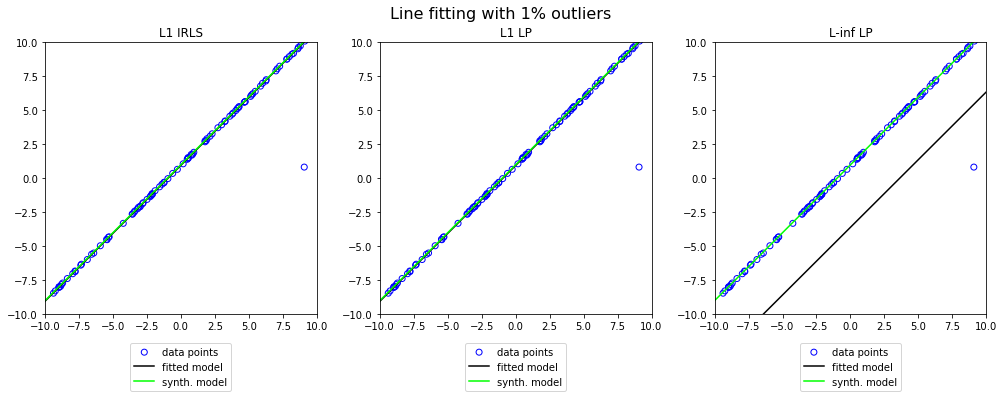

C:\Users\werer\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.7168e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


IRLS L1: Line(a=0.9986977152849801, b=0.9551899181623384)
LP L1: Line(a=0.9988183536440768, b=0.9473857781480134)
LP L-inf: Line(a=0.4767831422597064, b=3.0515841996671034)


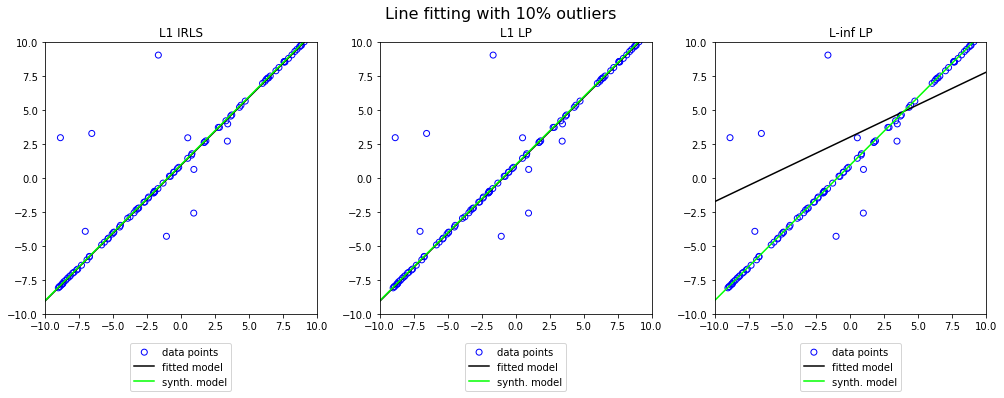

IRLS L1: Line(a=0.9931965206412331, b=0.9394630649763442)
LP L1: Line(a=0.9881923875125453, b=0.9294116649672617)
LP L-inf: Line(a=0.04959665705153249, b=0.017366240625655394)


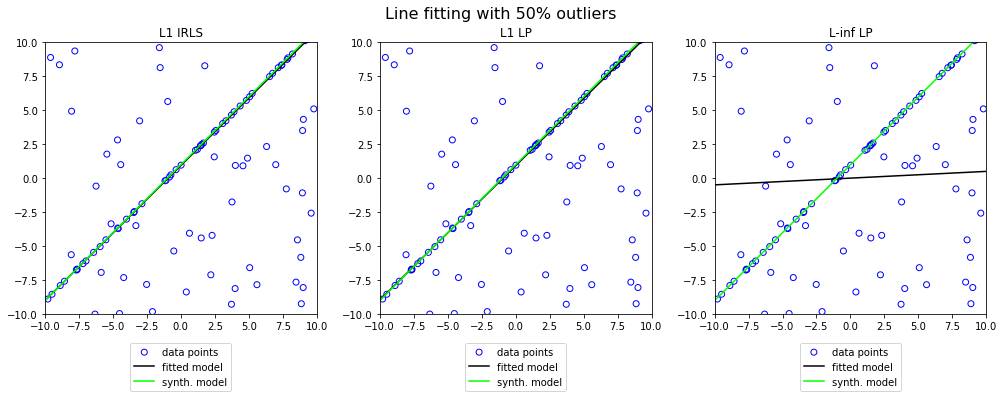

IRLS L1: Line(a=0.3428387236264687, b=-0.7765372592586901)
LP L1: Line(a=0.3428760366762784, b=-0.776852654014351)
LP L-inf: Line(a=0.06901839749706618, b=0.2781416793793614)


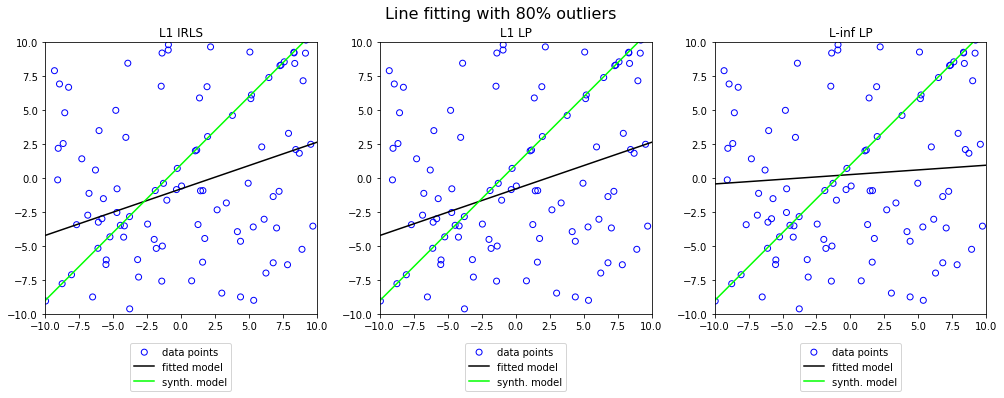

In [91]:
# Plotting the results. No need to change this code
for r in [0.0, 0.01, 0.1, 0.5, 0.8]:
    points = generate_line_points(r)
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)

    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")

    plot_line(axes[0], points, irls_l1_line, Line(1, 1), title="L1 IRLS")
    plot_line(axes[1], points, lp_l1_line, Line(1, 1), title="L1 LP")
    plot_line(axes[2], points, lp_l_inf_line, Line(1, 1), title="L-inf LP")
    
    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
    plt.show()
    plt.close(fig)

### Discussion 

<b style="color:red">Discuss the results obtained by these methods</b>

_TODO_: Your answer here